In [3]:
using TSSM
using PyPlot
include("time_stepper.jl");

 *** OPENMP n_threads =           8
 *** OPENMP n_threads =           8
 W: could not import fftw wisdom file


## Nonlinear Schrödinger equation without potential

The soliton
$$\psi_\mathrm{ex}(x,t)=\frac{a\mathrm{e}^{\frac{1}{2}\mathrm{i}((a^2-b^2)t-bx)}}{\cosh(a(bt+x-c))}$$ 
is the exact solution of the cubic nonlinear Schrödinger
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\Delta\psi(x,t)+\kappa|\psi(x,t)|^2\psi(x,t),
\quad \psi(x,0) = \psi_\mathrm{ex}(x,0),$$
where the cubic coupling parameter $\kappa=-1$, and $a,b,c\in\mathbb{R}$ are arbitrarily chosen parameters. 

In [4]:
const κ = -1
const a = 2
const b = 1
const c = 0
function soliton(x, t)
    h = (a^2 - b^2)/2*t - b*x
    (a./cosh(a*(b*t+x-c))).*exp(1im*h) 
end    

soliton (generic function with 1 method)

We use a Fourier spectral method on the computational domain  $[x_\mathrm{min},x_\mathrm{max}]=[-16,16]$ with $n_x=2048$ discretization points:

In [5]:
nx = 2048
xmin = -16
xmax = +16
method = Schroedinger1D(nx, xmin, xmax, cubic_coupling=κ)

TSSM.Schroedinger1D{Float64}(Ptr{Void} @0x0000000003cb5db0)

We integrate from $t_0=0$ to $t_\mathrm{end}=1$ with initial data $\psi_\mathrm{ex}(x,t_0)$. As reference solution to be compared with the numerical solution at $t=t_\mathrm{end}$ we use the exact solution $\psi_\mathrm{ex}(x,t_\mathrm{end})$:

In [6]:
t0 = 0
tend = 1
psi = wave_function(method)
psi_ref = wave_function(method)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)  # reference solution at t=tend

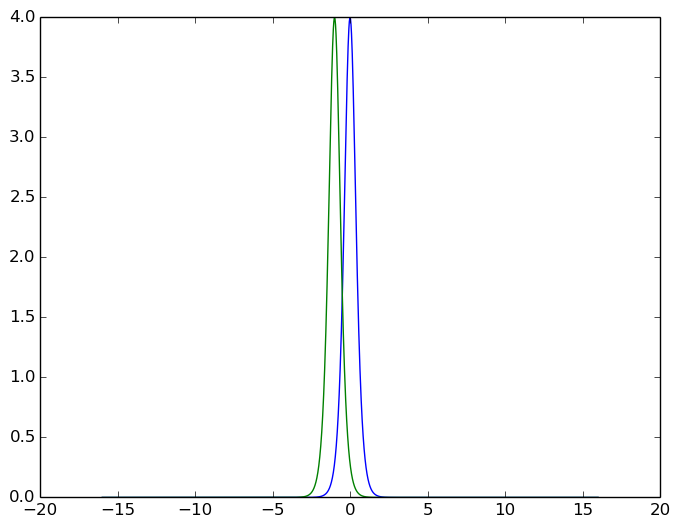

In [7]:
plot(get_nodes(method), abs(get_data(psi)).^2)
hold(true)
plot(get_nodes(method), abs(get_data(psi_ref)).^2)
hold(false)

Global error at $t=t_\mathrm{end}$ for Strang splitting:

In [8]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=Strang, rows=12) 
; 

             dt         err      p
-----------------------------------
  1   1.000e+00   1.586e+00
  2   5.000e-01   9.603e-01   0.72
  3   2.500e-01   4.448e-01   1.11
  4   1.250e-01   1.502e-01   1.57
  5   6.250e-02   4.157e-02   1.85
  6   3.125e-02   1.071e-02   1.96
  7   1.563e-02   2.698e-03   1.99
  8   7.813e-03   6.758e-04   2.00
  9   3.906e-03   1.690e-04   2.00
 10   1.953e-03   4.226e-05   2.00
 11   9.766e-04   1.057e-05   2.00
 12   4.883e-04   2.642e-06   2.00


Next we use a scheme of order 5 (method "PP 5/6 A" from http://www.asc.tuwien.ac.at/~winfried/splitting):


In [9]:
scheme_5 = ( 0.201651044312324230,   0.578800656272664932, 
             0.562615975356569200,   0.273128836056524479, 
             0.253874038247554845,  -0.102733803148432142, 
            -0.835351693190370636,   0.068014946093165092, 
             0.068014946093165092,  -0.835351693190370636,
            -0.102733803148432142,   0.253874038247554845, 
             0.273128836056524479,   0.562615975356569200, 
             0.578800656272664932,   0.201651044312324230 )          
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_5, rows=10) 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   2.041e+00
  2   5.000e-01   5.641e-01   1.85
  3   2.500e-01   8.913e-02   2.66
  4   1.250e-01   7.838e-03   3.51
  5   6.250e-02   3.703e-04   4.40
  6   3.125e-02   5.960e-06   5.96
  7   1.563e-02   5.499e-08   6.76
  8   7.813e-03   1.083e-09   5.67
  9   3.906e-03   2.675e-11   5.34
 10   1.953e-03   1.161e-12   4.53


## Linear Schrödinger equation with time dependent potential

The exact solution of the *linear* Schrödinger equation
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\Delta\psi(x,t)+V(x,t)\psi(x,t),
\quad \psi(x,0) = \psi_\mathrm{ex}(x,0),$$
with time dependent potential
$$V(x,t)=\kappa|\psi_\mathrm{ex}(x,t)|^2=\frac{\kappa a^2}{\cosh(a(bt+x-c))^2}$$
is by construction $\psi_\mathrm{ex}(x,t)$ form above.

In [10]:
#V1(x,t) = κ*abs(soliton(x,t)).^2
V1(x,t) = κ*a^2./cosh(a*(b*t+x-c)).^2
method = Schroedinger1D(nx, xmin, xmax, potential_t=V1)
psi = wave_function(method)
psi_ref = wave_function(method)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)  # reference solution at t=tend

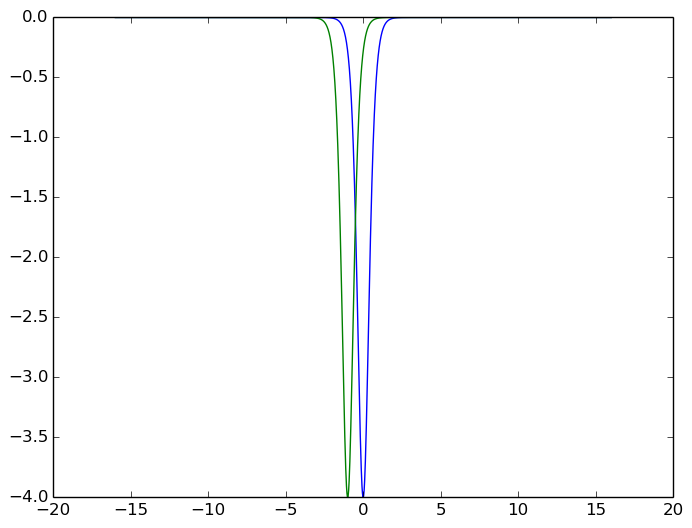

In [11]:
plot(get_nodes(method), get_potential_t(method, 0))
hold(true)
plot(get_nodes(method), get_potential_t(method, 1))
hold(false)

We use the the scheme of order 5 from above:

In [12]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_5, rows=10) 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.193e+00
  2   5.000e-01   2.502e-01   2.25
  3   2.500e-01   2.749e-02   3.19
  4   1.250e-01   2.231e-03   3.62
  5   6.250e-02   1.215e-04   4.20
  6   3.125e-02   2.019e-06   5.91
  7   1.563e-02   1.338e-08   7.24
  8   7.813e-03   3.629e-10   5.20
  9   3.906e-03   1.116e-11   5.02
 10   1.953e-03   6.016e-13   4.21


Note that time is propagated together with operator A by default:

In [13]:
get_propagate_time_together_with_A(method)

true

We can propagate time explicitly, i.e. use an ABC scheme where time is propagated by operator C.
For this we have to specify, that time should not be propagated together with operator A (otherwise time would be propagated twice).
We use an ABC scheme of order 3 (method "PP 3/4 A 3" from http://www.asc.tuwien.ac.at/~winfried/splitting):


In [14]:
set_propagate_time_together_with_A!(method, false)
#ABC scheme PP 3/4 A 3 
scheme_3 = (  0.461601939364879971, -0.266589223588183997,  -0.360420727960349671,
             -0.0678710530507800801, 0.0924576733143338354,  0.579154058410941403,
             -0.0958868852260720250, 0.674131550273850162,   0.483422668461380403,
              0.483422668461380403,  0.674131550273850162,  -0.0958868852260720250,
              0.579154058410941403,  0.0924576733143338354, -0.0678710530507800801,
             -0.360420727960349671, -0.266589223588183997,   0.461601939364879971 )
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_3, rows=10, 
              operator_sequence="ABT") 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.341e+00
  2   5.000e-01   4.789e-01   1.49
  3   2.500e-01   9.634e-02   2.31
  4   1.250e-01   1.148e-02   3.07
  5   6.250e-02   1.110e-03   3.37
  6   3.125e-02   1.249e-04   3.15
  7   1.563e-02   1.552e-05   3.01
  8   7.813e-03   1.938e-06   3.00
  9   3.906e-03   2.421e-07   3.00
 10   1.953e-03   3.027e-08   3.00


In [15]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_3, rows=10, 
              operator_sequence="ATB") 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.128e+00
  2   5.000e-01   5.461e-01   1.05
  3   2.500e-01   1.794e-01   1.61
  4   1.250e-01   3.064e-02   2.55
  5   6.250e-02   2.031e-03   3.91
  6   3.125e-02   5.079e-05   5.32
  7   1.563e-02   3.790e-06   3.74
  8   7.813e-03   4.429e-07   3.10
  9   3.906e-03   5.441e-08   3.03
 10   1.953e-03   6.771e-09   3.01


## Nonlinear Schrödinger equation with time dependent potential

The exact solution of the *nonlinear* Schrödinger equation
$$\mathrm{i}\frac{\partial}{\partial t}\psi(x,t)=-\frac{1}{2}\Delta\psi(x,t)+V_\alpha(x,t)\psi(x,t)+\alpha\kappa|\psi(x,t)|^2\psi(x,t),\quad\psi(x,0) = \psi_\mathrm{ex}(x,0),$$
with time dependent potential
$$V_\alpha(x,t)= (1-\alpha)\kappa|\psi_\mathrm{ex}(x,t)|^2=\frac{(1-\alpha)\kappa a^2}{\cosh(a(bt+x-c))^2}$$
and, e.g., $\alpha=\frac{1}{2}$ is again given by $\psi_\mathrm{ex}(x,t)$ form above.

In [16]:
const α=0.5
#V2(x,t) = (1-α)*κ*abs(soliton(x,t)).^2
V2(x,t) = (1-α)*κ*a^2./cosh(a*(b*t+x-c)).^2
method = Schroedinger1D(nx, xmin, xmax, potential_t=V2, cubic_coupling=α*κ)
psi = wave_function(method)
psi_ref = wave_function(method)
set!(psi, soliton, t0)        # initial data at t=t0
set!(psi_ref, soliton, tend)  # reference solution at t=tend

In [17]:
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_5, rows=10) 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.903e+00
  2   5.000e-01   4.186e-01   2.18
  3   2.500e-01   5.423e-02   2.95
  4   1.250e-01   4.485e-03   3.60
  5   6.250e-02   2.065e-04   4.44
  6   3.125e-02   3.142e-06   6.04
  7   1.563e-02   2.569e-08   6.93
  8   7.813e-03   6.290e-10   5.35
  9   3.906e-03   1.839e-11   5.10
 10   1.953e-03   8.389e-13   4.45


In [18]:
set_propagate_time_together_with_A!(method, false)
global_orders(psi, psi_ref, t0, tend, tend-t0, scheme=scheme_3, rows=10,
              operator_sequence="ABT") 
;

             dt         err      p
-----------------------------------
  1   1.000e+00   1.128e+00
  2   5.000e-01   4.499e-01   1.33
  3   2.500e-01   9.886e-02   2.19
  4   1.250e-01   1.328e-02   2.90
  5   6.250e-02   1.170e-03   3.50
  6   3.125e-02   1.169e-04   3.32
  7   1.563e-02   1.437e-05   3.02
  8   7.813e-03   1.793e-06   3.00
  9   3.906e-03   2.241e-07   3.00
 10   1.953e-03   2.803e-08   3.00


## Error estimators

### Embedded Schemes

In [19]:
scheme_5A = ( 0.201651044312324230,   0.578800656272664932, 
              0.562615975356569200,   0.273128836056524479, 
              0.253874038247554845,  -0.102733803148432142, 
             -0.726560425753743689,  -0.800888361904193390,
             -0.0944858667147550235,  0.259957296127666422,
              0.246962230324312930,   0.594143062900597984,
              0.5559430042277375075,  0.197592313695171715 )
set_propagate_time_together_with_A!(method, true)
local_orders(psi, soliton, t0, tend-t0, EmbeddedScheme(scheme_5A, scheme_5, 4), operator_sequence="AB", rows=10)
;

             dt         err      p         err      p
------------------------------------------------------
  1   1.000e+00   1.984e+00          1.903e+00
  2   5.000e-01   3.451e-01   2.52   2.805e-01   2.76
  3   2.500e-01   3.316e-02   3.38   2.582e-02   3.44
  4   1.250e-01   2.105e-03   3.98   1.609e-03   4.00
  5   6.250e-02   8.829e-05   4.58   6.257e-05   4.68
  6   3.125e-02   2.459e-06   5.17   1.380e-06   5.50
  7   1.563e-02   5.667e-08   5.44   2.049e-08   6.07
  8   7.813e-03   1.428e-09   5.31   2.925e-10   6.13
  9   3.906e-03   4.101e-11   5.12   4.418e-12   6.05
 10   1.953e-03   1.251e-12   5.04   6.869e-14   6.01


### Palindromic Schemes

In [20]:
set_propagate_time_together_with_A!(method, true)
local_orders(psi, soliton, t0, tend-t0, PalindromicScheme(scheme_5, 5), operator_sequence="AB", rows=10)
;

             dt         err      p         err      p
------------------------------------------------------
  1   1.000e+00   1.903e+00          1.230e+00
  2   5.000e-01   2.805e-01   2.76   1.947e-01   2.66
  3   2.500e-01   2.582e-02   3.44   1.958e-02   3.31
  4   1.250e-01   1.609e-03   4.00   1.393e-03   3.81
  5   6.250e-02   6.257e-05   4.68   5.982e-05   4.54
  6   3.125e-02   1.380e-06   5.50   1.297e-06   5.53
  7   1.563e-02   2.049e-08   6.07   1.569e-08   6.37
  8   7.813e-03   2.925e-10   6.13   1.401e-10   6.81
  9   3.906e-03   4.418e-12   6.05   1.133e-12   6.95
 10   1.953e-03   6.869e-14   6.01   1.025e-14   6.79


### Defect based error estimator

We need the derivative with respect to $t$ of the time-dependent potential 
$$V_\alpha(x,t)= (1-\alpha)\kappa|\psi_\mathrm{ex}(x,t)|^2=\frac{(1-\alpha)\kappa a^2}{\cosh(a(bt+x-c))^2}$$
from above:
$$\frac{\partial}{\partial t}V_\alpha(x,t)=\frac{2(1-\alpha)\kappa a^3b\sinh(a(bt+x-c))}{\cosh(a(bt+x-c))^3}$$ 

In [21]:
V2(x,t) = (1-α)κ*a^2./cosh(a*(b*t+x-c)).^2
V2_derivative(x,t) = -2*(1-α)*κ*a^3*b.*sinh(a*(b*t+x-c))./cosh(a*(b*t+x-c)).^3

#method = Schroedinger1D(nx, xmin, xmax, potential_t=V2, potential_t_derivative=V2_derivative, cubic_coupling=-α)
#psi = wave_function(method)
#psi_ref = wave_function(method)
#set!(psi, soliton, t0)        # initial data at t=t0
#set!(psi_ref, soliton, tend)  # reference solution at t=tend

set_potential_t_derivative!(method, V2_derivative)

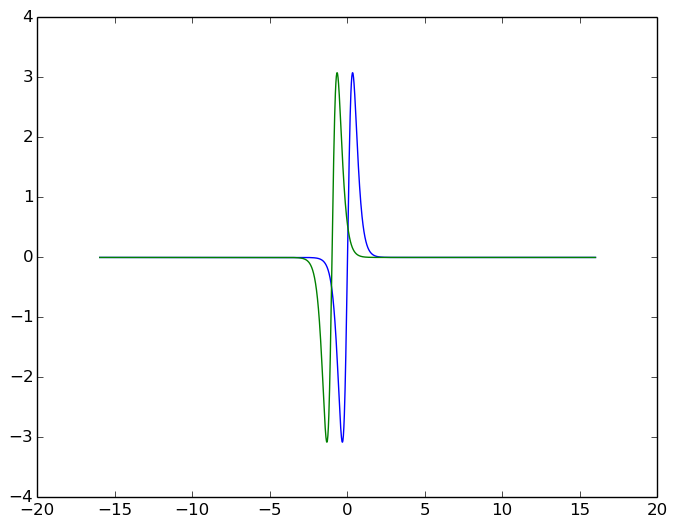

In [22]:
plot(get_nodes(method), get_potential_t_derivative(method, 0))
hold(true)
plot(get_nodes(method), get_potential_t_derivative(method, 1))
hold(false)

In [23]:
local_orders(psi, soliton, t0, tend-t0, DefectBasedScheme(scheme_5, 5), operator_sequence="AB", rows=10)
;

             dt         err      p         err      p
------------------------------------------------------
  1   1.000e+00   1.903e+00          2.406e+00
  2   5.000e-01   2.805e-01   2.76   1.998e-01   3.59
  3   2.500e-01   2.582e-02   3.44   1.418e-02   3.82
  4   1.250e-01   1.609e-03   4.00   7.116e-04   4.32
  5   6.250e-02   6.257e-05   4.68   2.422e-05   4.88
  6   3.125e-02   1.380e-06   5.50   4.864e-07   5.64
  7   1.563e-02   2.049e-08   6.07   5.567e-09   6.45
  8   7.813e-03   2.925e-10   6.13   4.729e-11   6.88
  9   3.906e-03   4.418e-12   6.05   3.734e-13   6.98
 10   1.953e-03   6.869e-14   6.01   7.024e-15   5.73
